In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [184]:
def predict(w, x, b):
    return np.dot(x, w) + b

def MSE(w, x, b, y):
    return np.mean((y - predict(w, x, b)) ** 2)/10000

def random_split(data, ratio_x, ratio_y):
    size = data.shape[0]
    size_x = int(size * ratio_x)
    size_y = int(size * ratio_y)
    all_indices = np.arange(size)
    np.random.shuffle(all_indices)
    indices_y = all_indices[:size_y]
    indices_x = all_indices[size_y:size_y + size_x]
    data_x = data[indices_x]
    data_y = data[indices_y]
    return data_x, data_y

def normalize_features(x):
    mean = np.mean(x, axis=0)
    std = np.std(x, axis=0)
    x_normalized = (x - mean) / std
    return x_normalized, mean, std


def compute_gradient(w, x, b, y):
    m = x.shape[0]
    predictions = predict(w, x, b)
    error = predictions - y
    w_gradient = np.dot(x.T, error) / m
    b_gradient = np.sum(error) / m
    return w_gradient, b_gradient


def cost_function(w, x, b, y):
    m = x.shape[0]
    predictions = predict(w, x, b)
    squared_errors = np.square(predictions - y)
    total_cost = np.sum(squared_errors) / (2 * m)
    return total_cost/1000


def gradient_descent(w, x, b, y, iterations, alpha):
    J_history = []
    b_history = []
    w_history = []
    m = x.shape[0]
    for i in range(iterations):
        w_gradient, b_gradient = compute_gradient(w, x, b, y)
        w -= alpha * w_gradient
        b -= alpha * b_gradient
        J_history.append(cost_function(w, x, b, y))
        w_history.append(w.copy())
        b_history.append(b)
        if i % 10 == 0:
            print(f'Iteration {i}, Cost {J_history[-1]}, W: {w}, B: {b}')
    return w_history, b_history, J_history, w, b


In [185]:
df = pd.read_csv('data.csv')
x_train_norm, mean, std = normalize_features(df.iloc[:, :-1].values)
y_train = df.iloc[:, -1].values
w_init = np.zeros(x_train_norm.shape[1])
b_init = 0
iters = 1000
alpha = 0.1
w_hist, b_hist, J_hist, w_final, b_final = gradient_descent(w_init, x_train_norm, b_init, y_train, iters, alpha)

print('Final W:', w_final)
print('Final B:', b_final)

Iteration 0, Cost 60788695.72635675, W: [ 7662.99110412  6175.11836092 -6267.47950109 -4112.2686549 ], B: 38117.64705882353
Iteration 10, Cost 7439552.063833423, W: [ 37459.93807925  17602.91831837 -20318.32226502  -6344.15403344], B: 261559.25513745882
Iteration 20, Cost 1032254.2538244593, W: [ 47146.4414279   14568.61651424 -21130.6753508   -2074.49750239], B: 339468.526495753
Iteration 30, Cost 229065.60674974474, W: [ 52217.54805219  11402.95863607 -21892.97499246   -411.00542873], B: 366633.8097022905
Iteration 40, Cost 118911.0553216398, W: [ 55172.89844307   8601.49199065 -22682.34419754   -102.53435004], B: 376105.7582756207
Iteration 50, Cost 97635.97283224948, W: [ 57062.67211182   6177.00386614 -23381.54975807   -397.56335039], B: 379408.4225288769
Iteration 60, Cost 89599.79509416125, W: [ 58388.25890607   4098.04922765 -23952.42769248   -938.97967275], B: 380559.99034887634
Iteration 70, Cost 84712.8294934594, W: [ 59394.44361147   2322.85217848 -24394.99064343  -1560.674

In [186]:
x_predict = np.array([2500, 4, 10, 5])
x_predict_normalized = (x_predict - mean) / std
print('Prediction:', predict(w_final, x_predict_normalized, b_final))

Prediction: 488354.4354786487


In [187]:
x_test = pd.read_csv('test_data.csv')
x_test_norm, mean, std = normalize_features(x_test.iloc[:, :-1].values)
y_test = x_test.iloc[:, -1].values
y_pred = predict(w_final, x_test_norm, b_final)
mse = MSE(w_final, x_test_norm, b_final, y_test)
mse_train = MSE(w_final, x_train_norm, b_final, y_train)
print('Mean Squared Error on Test Set:', mse)
print('Mean Squared Error on Train Set:', mse_train)
import numpy as np

def k_fold_cross_validation(x, y, k, iterations, alpha):
    fold_size = x.shape[0] // k
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    
    folds = [indices[i * fold_size:(i + 1) * fold_size] for i in range(k)]
    
    best_alpha = None
    best_iterations = None
    best_cost = float('inf')
    
    for alpha_val in alpha:
        for iter_val in iterations:
            fold_costs = []
            for i in range(k):
                val_indices = folds[i]
                train_indices = np.concatenate(folds[:i] + folds[i+1:])
                
                x_train, y_train = x[train_indices], y[train_indices]
                x_val, y_val = x[val_indices], y[val_indices]
                
                # Normalize features
                x_train_norm, mean, std = normalize_features(x_train)
                x_val_norm = (x_val - mean) / std
                
                # Initialize weights and bias
                w = np.zeros(x_train_norm.shape[1])
                b = 0
                
                # Run gradient descent
                w_history, b_history, J_history, w_final, b_final = gradient_descent(
                    w, x_train_norm, b, y_train, iter_val, alpha_val
                )
                
                # Compute cost on a validation set
                x_val_norm = (x_val - mean) / std
                cost = cost_function(w_final, x_val_norm, b_final, y_val)
                fold_costs.append(cost)
            
            avg_cost = np.mean(fold_costs)
            if avg_cost < best_cost:
                best_cost = avg_cost
                best_alpha = alpha_val
                best_iterations = iter_val
    
    return best_alpha, best_iterations

# alphas = [0.001, 0.01, 0.1, 0.5, 0.05, 0.034]
# iterations = [100, 500, 1000, 5000, 10000]
# k = 5
# alpha, best_iters = k_fold_cross_validation(x_train_norm, y_train, 5, iterations, alphas)
# print(alpha, best_iters)

Mean Squared Error on Test Set: 2598988139.3980255
Mean Squared Error on Train Set: 141778002.71595713


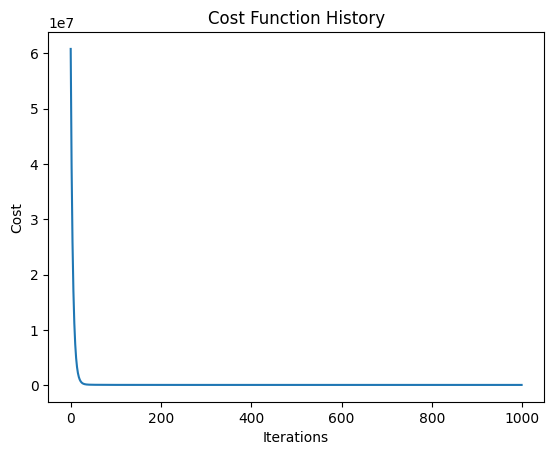

In [188]:
plt.plot(range(iters), J_hist)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost Function History')
plt.show()